In [1]:
# Enable autoreload
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from tqdm.auto import tqdm
import pickle
from pathlib import Path
import numpy as np
from math import floor
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import matplotlib.pyplot as plt

pd.set_option('max_columns',None)
tqdm.pandas()

# Import Data

In [3]:
data_path = Path('./data/export_rech_2016_2020.pkl.bz2')

if data_path.exists():
    df_raw = pd.read_pickle(data_path)
    
display(df_raw.head(10))
display(df_raw.info())

,IMP_ID,GJ,IMPORT,MUFO_REFERENZ_NR,BARCODE_NR,VERANST_SEGMENT,REKLA_JN,VG_DATUM_VON,VG_ORT,VG_RAUM,NUTZFALL_VON_DT,NUTZFALL_RAUM,MUSIKLEITER_NAME,KAPELLE_NAME,TARIF_NR,TARIF_BEZ,NUTZFALL_NR,VG_INKASSO,INKASSO_NETTO,INKASSO_BRUTTO,VERANST_GESCHAEFTSZEICHEN,VERANST_NAME,VERANST_STRASSE,VERANST_PLZ,VERANST_ORT,NUTZLIZNEHM_GESCHAEFTSZEICHEN,NUTZLIZNEHM_NAME,NUTZLIZNEHM_VORNAME,NUTZLIZNEHM_STRASSE,NUTZLIZNEHM_PLZ,NUTZLIZNEHM_ORT,LOCATION,BAND,PROMOTER
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9938765,24643,2016,ABRE U INKA 2016,NaN,5027961220,4.0,NONRekla,2014-02-09,LISBERG,TURNHALLE SV RW LISBERG,20140209.0,TURNHALLE SV RW LISBERG,NaN,NaN,892,U-K (MUSIKER),18293163,140.00,NaN,NaN,1035530900,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V,SCHINDHOLZWEG 17,96194,WALSDORF,1510423300,BAYERISCHER BLASMUSIKVERBAND,NaN,NaN,80084,MUENCHEN,LISBERG TURNHALLE SV RW LISBERG,NaN,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V 96194
9938766,24643,2016,ABRE U INKA 2016,NaN,5027961235,6.0,NONRekla,2014-02-08,LISBERG,TURNHALLE SV RW LISBERG,20140208.0,TURNHALLE SV RW LISBERG,STAERK REINHOLD,DAS BOEHMISCHE FEUER,892,U-K (MUSIKER),18293091,210.00,NaN,NaN,1035530900,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V,SCHINDHOLZWEG 17,96194,WALSDORF,1510423300,BAYERISCHER BLASMUSIKVERBAND,NaN,NaN,80084,MUENCHEN,LISBERG TURNHALLE SV RW LISBERG,DAS BOEHMISCHE FEUER,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V 96194
9938851,24643,2016,ABRE U INKA 2016,NaN,5044481411,3.0,NONRekla,2014-03-15,MUENCHEN,WERNER-VON-SIEMENS-SCHULZENTRUM,20140315.0,WERNER-VON-SIEMENS-SCHULZENTRUM,NaN,NaN,974,U-K (MUSIKER) MINDESTVERGUETUNG,18483465,72.50,NaN,NaN,2000179545,BLASORCHESTER ST. MICHAEL MUENCHEN-PERLACH E.V,HOCHAECKERSTR. 123,81737,MUENCHEN,1510423300,BAYERISCHER BLASMUSIKVERBAND,NaN,NaN,80084,MUENCHEN,MUENCHEN WERNER-VON-SIEMENS-SCHULZENTRUM,NaN,BLASORCHESTER ST. MICHAEL MUENCHEN-PERLACH E.V...
9938852,24643,2016,ABRE U INKA 2016,NaN,5044481427,2.0,NONRekla,2014-03-14,MUENCHEN,PFARRHEIM UND KIRCHE,20140314.0,PFARRHEIM UND KIRCHE,NaN,NaN,974,U-K (MUSIKER) MINDESTVERGUETUNG,18483423,34.80,NaN,NaN,2000179545,BLASORCHESTER ST. MICHAEL MUENCHEN-PERLACH E.V,HOCHAECKERSTR. 123,81737,MUENCHEN,1510423300,BAYERISCHER BLASMUSIKVERBAND,NaN,NaN,80084,MUENCHEN,MUENCHEN PFARRHEIM UND KIRCHE,NaN,BLASORCHESTER ST. MICHAEL MUENCHEN-PERLACH E.V...
9938853,24643,2016,ABRE U INKA 2016,NaN,5044481469,2.0,NONRekla,2014-02-09,GRAFENRHEINFELD,KULTURHALLE GRAFENRHEINFELD,20140209.0,KULTURHALLE GRAFENRHEINFELD,NaN,NaN,892,U-K (MUSIKER),18184927,34.80,NaN,NaN,1023588500,MUSIKVEREIN WERNECK E.V,VON-FECHENBACH-STR. 27,97440,WERNECK,1510423300,BAYERISCHER BLASMUSIKVERBAND,NaN,NaN,80084,MUENCHEN,GRAFENRHEINFELD KULTURHALLE GRAFENRHEINFELD,NaN,MUSIKVEREIN WERNECK E.V 97440
9938854,24643,2016,ABRE U INKA 2016,NaN,5044481474,2.0,NONRekla,2014-02-15,FRIESENRIED,VEREINSHEIM TSV FRIESENRIED,20140215.0,VEREINSHEIM TSV FRIESENRIED,NaN,NaN,1087,U-V II. 1 (+II 2),18338753,42.56,NaN,NaN,111484400,BLASKAPELLE BLOECKTACH E.V,BUCHENWEG 4,87654,FRIESENRIED,1510423300,BAYERISCHER BLASMUSIKVERBAND,NaN,NaN,80084,MUENCHEN,FRIESENRIED VEREINSHEIM TSV FRIESENRIED,NaN,BLASKAPELLE BLOECKTACH E.V 87654
9938855,24643,2016,ABRE U INKA 2016,NaN,5044481582,2.0,NONRekla,2014-02-01,HEIMENKIRCH,PAUL-BAECK HAUS,20140201.0,PAUL-BAECK HAUS,NaN,NaN,892,U-K (MUSIKER),17988571,17.44,NaN,NaN,2000147091,MARKT HEIMENKIRCH,LINDAUER STR. 2,88178,HEIMENKIRCH,2000147091,MARKT HEIMENKIRCH,NaN,LINDAUER STR. 2,88178,HEIMENKIRCH,HEIMENKIRCH PAUL-BAECK HAUS,NaN,MARKT HEIMENKIRCH 88178
9938856,24643,2016,ABRE U INKA 2016,NaN,5044482716,4.0,NONRekla,2014-02-15,OBERHAID,SPORTHEIM UND SPORTHALLE RSC OBERHAID,20140215.0,SPORTHEIM UND SPORTHALLE RSC OBERHAID,NaN,NaN,1087,U-V II. 1 (+II 2),18338725,127.65,NaN,NaN,1035082100,BLASMUSIKVEREIN OBERHAID E.V,SEEWEG 5,96173,OBERHAID,1510423300,BAYERISCHER BLASMUSIKVERBAND,NaN,NaN,80084,MUENCHEN,OBERHAID SPORTHEIM UND SPORTHALLE RSC OBERHAID,NaN,BLASMUSIKVEREIN OBERHAID E.V 96173
9938857,24643,2016,ABRE U INKA 2016,NaN,5044482763,2.0,NONRekla,

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3151842 entries, 9938765 to 13791338
Data columns (total 34 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   IMP_ID                         int64         
 1   GJ                             int64         
 2   IMPORT                         category      
 3   MUFO_REFERENZ_NR               object        
 4   BARCODE_NR                     int64         
 5   VERANST_SEGMENT                float64       
 6   REKLA_JN                       category      
 7   VG_DATUM_VON                   datetime64[ns]
 8   VG_ORT                         category      
 9   VG_RAUM                        category      
 10  NUTZFALL_VON_DT                float64       
 11  NUTZFALL_RAUM                  object        
 12  MUSIKLEITER_NAME               object        
 13  KAPELLE_NAME                   object        
 14  TARIF_NR                       int64         
 15  TARIF_BE

None

In [4]:
df_featurize = df_raw[[
    'VG_INKASSO', 'VERANST_SEGMENT', 'VG_ORT', 'VG_RAUM', 'VG_DATUM_VON', 'KAPELLE_NAME',
    'VERANST_NAME', 'VERANST_PLZ', 'TARIF_NR', 'LOCATION', 'BAND', 'PROMOTER'
]].copy()

display(df_featurize.head(10))

,VG_INKASSO,VERANST_SEGMENT,VG_ORT,VG_RAUM,VG_DATUM_VON,KAPELLE_NAME,VERANST_NAME,VERANST_PLZ,TARIF_NR,LOCATION,BAND,PROMOTER
ID,,,,,,,,,,,,
9938765,140.00,4.0,LISBERG,TURNHALLE SV RW LISBERG,2014-02-09,NaN,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V,96194,892,LISBERG TURNHALLE SV RW LISBERG,NaN,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V 96194
9938766,210.00,6.0,LISBERG,TURNHALLE SV RW LISBERG,2014-02-08,DAS BOEHMISCHE FEUER,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V,96194,892,LISBERG TURNHALLE SV RW LISBERG,DAS BOEHMISCHE FEUER,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V 96194
9938851,72.50,3.0,MUENCHEN,WERNER-VON-SIEMENS-SCHULZENTRUM,2014-03-15,NaN,BLASORCHESTER ST. MICHAEL MUENCHEN-PERLACH E.V,81737,974,MUENCHEN WERNER-VON-SIEMENS-SCHULZENTRUM,NaN,BLASORCHESTER ST. MICHAEL MUENCHEN-PERLACH E.V...
9938852,34.80,2.0,MUENCHEN,PFARRHEIM UND KIRCHE,2014-03-14,NaN,BLASORCHESTER ST. MICHAEL MUENCHEN-PERLACH E.V,81737,974,MUENCHEN PFARRHEIM UND KIRCHE,NaN,BLASORCHESTER ST. MICHAEL MUENCHEN-PERLACH E.V...
9938853,34.80,2.0,GRAFENRHEINFELD,KULTURHALLE GRAFENRHEINFELD,2014-02-09,NaN,MUSIKVEREIN WERNECK E.V,97440,892,GRAFENRHEINFELD KULTURHALLE GRAFENRHEINFELD,NaN,MUSIKVEREIN WERNECK E.V 97440
9938854,42.56,2.0,FRIESENRIED,VEREINSHEIM TSV FRIESENRIED,2014-02-15,NaN,BLASKAPELLE BLOECKTACH E.V,87654,1087,FRIESENRIED VEREINSHEIM TSV FRIESENRIED,NaN,BLASKAPELLE BLOECKTACH E.V 87654
9938855,17.44,2.0,HEIMENKIRCH,PAUL-BAECK HAUS,2014-02-01,NaN,MARKT HEIMENKIRCH,88178,892,HEIMENKIRCH PAUL-BAECK HAUS,NaN,MARKT HEIMENKIRCH 88178
9938856,127.65,4.0,OBERHAID,SPORTHEIM UND SPORTHALLE RSC OBERHAID,2014-02-15,NaN,BLASMUSIKVEREIN OBERHAID E.V,96173,1087,OBERHAID SPORTHEIM UND SPORTHALLE RSC OBERHAID,NaN,BLASMUSIKVEREIN OBERHAID E.V 96173
9938857,45.10,2.0,MUENCHEN,DIE GOLDENE BAR,2014-02-05,NaN,CONDE NAST VERLAG GMBH,80333,1087,MUENCHEN DIE GOLDENE BAR,NaN,CONDE NAST VERLAG GMBH 80333


# Add Descriptive Statistics

In [5]:
data_path_descr_stat=Path('./data/export_descr_stat_2016_2020.pkl.bz2')

data_path_loc = Path('./data/export_descr_stat_location_2016_2020.pkl.zip')
data_path_band = Path('./data/export_descr_stat_band_2016_2020.pkl.zip')
data_path_promoter = Path('./data/export_descr_stat_promoter_2016_2020.pkl.zip')

stat_var = ['LOCATION', 'BAND', 'PROMOTER']
df_stat = {}


def get_descr_stat(row):
    def descr_stat(row, var):
        result = pd.Series(dtype='float64')

        if not pd.isnull(row[var]):
            inkasso = df_stat[var].loc[row[var]].copy()
            if len(inkasso) > 1:
                inkasso.remove(row['VG_INKASSO'])
                result = pd.Series(inkasso).describe(percentiles=percentiles)
                result = result.add_prefix('{}_'.format(var))

        result.name = row.name
        return result

    descr_stat_result = pd.Series(dtype='float64')
    for v in stat_var:
        descr_stat_result = descr_stat_result.append(descr_stat(row, v))

    return descr_stat_result


if data_path_descr_stat.exists() :
    df_featurize_descr_stat = pd.read_pickle(data_path_descr_stat)
    
elif data_path_loc.exists() and data_path_band.exists() and data_path_promoter.exists():
    df_loc = pd.read_pickle(data_path_loc)
    df_band = pd.read_pickle(data_path_band)
    df_promoter = pd.read_pickle(data_path_promoter)

    df_featurize_descr_stat = df_loc.merge(df_band, how='outer', on='ID').merge(df_promoter,
                                                                                how='outer',
                                                                                on='ID')
else:

    for v in tqdm(stat_var):
        df_stat[v] = df_featurize.groupby(v)['VG_INKASSO'].apply(list)

    percentiles = [round(x, 2) for x in np.linspace(0, 1, 21)[1:-1].tolist()]

    df_featurize_descr_stat = df_featurize.progress_apply(get_descr_stat, axis=1)
    df_featurize_descr_stat.to_pickle('./data/export_descr_stat_2016_2020.pkl.bz2', protocol=4)

display(df_featurize_descr_stat)

,BAND_10%,BAND_15%,BAND_20%,BAND_25%,BAND_30%,BAND_35%,BAND_40%,BAND_45%,BAND_5%,BAND_50%,BAND_55%,BAND_60%,BAND_65%,BAND_70%,BAND_75%,BAND_80%,BAND_85%,BAND_90%,BAND_95%,BAND_count,BAND_max,BAND_mean,BAND_min,BAND_std,LOCATION_10%,LOCATION_15%,LOCATION_20%,LOCATION_25%,LOCATION_30%,LOCATION_35%,LOCATION_40%,LOCATION_45%,LOCATION_5%,LOCATION_50%,LOCATION_55%,LOCATION_60%,LOCATION_65%,LOCATION_70%,LOCATION_75%,LOCATION_80%,LOCATION_85%,LOCATION_90%,LOCATION_95%,LOCATION_count,LOCATION_max,LOCATION_mean,LOCATION_min,LOCATION_std,PROMOTER_10%,PROMOTER_15%,PROMOTER_20%,PROMOTER_25%,PROMOTER_30%,PROMOTER_35%,PROMOTER_40%,PROMOTER_45%,PROMOTER_5%,PROMOTER_50%,PROMOTER_55%,PROMOTER_60%,PROMOTER_65%,PROMOTER_70%,PROMOTER_75%,PROMOTER_80%,PROMOTER_85%,PROMOTER_90%,PROMOTER_95%,PROMOTER_count,PROMOTER_max,PROMOTER_mean,PROMOTER_min,PROMOTER_std
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9938765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.002,32.780,32.780,32.78,32.780,32.780,37.404,39.901,23.520,47.50,47.500,70.550,107.521,137.770,139.37,139.370,139.9685,161.000,210.000,28.0,210.00,82.041786,23.52,63.602384,45.020,47.60,47.60,52.6125,61.635,67.650,67.65,67.725,33.41,68.40,69.075,95.490,125.1225,136.50,138.75,154.000,185.500,210.000,210.000,10.0,210.00,101.645000,21.80,68.027337
9938766,210.000,210.000,210.000,210.0000,210.000,210.000,210.00,210.0000,210.0000,210.000,210.000,210.000,210.000,210.000,210.0000,210.000,210.000,210.000,210.0000,2.0,210.00,210.000000,210.00,0.000000,30.002,32.780,32.780,32.78,32.780,32.780,37.404,39.901,23.520,47.50,47.500,70.550,107.521,137.770,139.37,139.370,139.9685,140.000,185.500,28.0,210.00,79.541786,23.52,59.638714,45.020,47.60,47.60,52.6125,61.635,67.650,67.65,67.725,33.41,68.40,69.075,95.490,125.1225,136.50,138.75,140.000,140.000,147.000,178.500,10.0,210.00,94.645000,21.80,58.584950
9938851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.616,72.524,75.874,87.54,99.574,254.156,272.560,335.620,52.624,396.10,396.100,398.458,401.640,406.286,410.87,454.280,499.9660,603.800,607.560,57.0,607.56,310.871053,36.88,190.826651,21.800,21.80,22.80,22.8000,23.050,23.050,23.05,34.800,20.22,34.80,37.280,37.280,37.4800,46.10,46.10,46.100,46.100,56.560,68.400,31.0,72.50,36.088387,18.64,15.365358
9938852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.800,22.800,22.800,22.80,30.000,35.296,36.784,37.280,20.232,37.28,37.280,37.360,37.600,37.680,37.68,42.732,46.1000,46.100,55.020,13.0,68.40,35.952308,16.38,13.458005,21.800,21.80,22.80,22.8000,23.050,23.050,23.05,34.800,20.22,37.28,37.280,37.280,41.8900,46.10,46.10,46.100,51.330,68.400,70.450,31.0,72.50,37.304516,18.64,16.694434
9938853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.220,54.720,73.760,92.20,106.040,154.720,194.706,200.860,29.063,206.11,286.005,317.602,358.090,421.870,480.39,489.122,502.6380,516.060,597.611,183.0,757.62,274.295027,11.02,197.330367,19.272,21.80,21.80,23.0500,36.900,46.100,46.10,54.188,18.64,89.60,93.200,107.050,115.2500,115.25,120.00,135.200,146.292,191.780,199.500,33.0,574.90,97.323333,18.64,103.515588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13791334,17.233,18.440,18.740,19.7600,22.800,23.300,23.99,24.1000,16.4185,24.400,24.700,33.506,38.640,39.601,43.7575,71.856,115.680,209.185,847.2600,128.0,5920.13,188.616406,13.54,676.309931,18.440,18.440,18.440,18.44,18.640,18.640,18.640,18.640,18.310,18.74,18.840,18.840,19.280,19.280,19.28,19.280,19.2800,19.280,21.736,68.0,23.05,19.059706,18.24,1.047101,18.440,18.44,18.44,18.4400,18.600,18.640,18.64,18.640,18.30,18.64,18

# NLTK Analysis

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mzuern1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## VG_RAUM

In [7]:
df_raw['VG_RAUM_clean']=df_raw['VG_RAUM'].astype(str).fillna('').map(lambda x: re.sub(r'\W+', ' ', x))
df_raw['VG_RAUM_tokenized']=df_raw['VG_RAUM_clean'].apply(word_tokenize, language='german')

flat_list = [item for sublist in df_raw['VG_RAUM_tokenized'].tolist() for item in sublist]

german_stop_words = stopwords.words('german')

text_wo_stop_words = [word for word in flat_list if word.lower() not in german_stop_words]

stopwords = [
    'ST', 'FREIEN', 'BAD', 'HAUS', 'EV', 'BERLIN', 'KATH', 'S', 'HOF', 'ALTE', 'MITTE', 'LUTH', 'MUENCHEN',
    'IRISH', 'MUSIK', 'KULTUR', 'FUER', 'EVANG', 'MARITIM', 'KOELN', 'U', 'TURN', 'E', 'STUTTGART', 'ALTES',
    'A', 'GASTES', 'THE', 'EUROPA', 'HANNOVER', 'STADT', 'BADEN', 'NUERNBERG', 'HAMBURG', 'NEUE',
    'EVANGELISCHE', 'LEIPZIG', 'B', 'DRESDEN', 'BREMEN', 'PETER', '1','ALTER'
]

text_wo_stop_words_2 = [word for word in text_wo_stop_words if word not in stopwords]

text_wo_stop_words_3 = ['KIRCHE' if 'KIRCHE' in word else word for word in text_wo_stop_words_2 ]

display(text_wo_stop_words_3)

['TURNHALLE',
 'SV',
 'RW',
 'LISBERG',
 'TURNHALLE',
 'SV',
 'RW',
 'LISBERG',
 'WERNER',
 'SIEMENS',
 'SCHULZENTRUM',
 'PFARRHEIM',
 'KIRCHE',
 'KULTURHALLE',
 'GRAFENRHEINFELD',
 'VEREINSHEIM',
 'TSV',
 'FRIESENRIED',
 'PAUL',
 'BAECK',
 'SPORTHEIM',
 'SPORTHALLE',
 'RSC',
 'OBERHAID',
 'GOLDENE',
 'BAR',
 'MEHRZWECKHALLE',
 'SONTHEIM',
 'JAHNHALLE',
 'TURNHALLE',
 'ALBERT',
 'BLANKERTZ',
 'VOLKSSCHULE',
 'STADTHALLE',
 'BAYREUTH',
 'SPORTPARKHALLE',
 'SCHWARZENFELD',
 'RESTAURANT',
 'STORCHENNEST',
 'ALTEN',
 'WIRT',
 'SCHLOSS',
 'AYSTETTEN',
 'REGENTENBAU',
 'DIV',
 'SAELE',
 'WANDELHALLE',
 'BAY',
 'STAATSBAD',
 'KISSINGEN',
 'JAHN',
 'TURNHALLE',
 'REGENSTAUF',
 'PFARRHEIM',
 'STULLN',
 'GASTHAUS',
 'KAINDL',
 'GEMEINDEHALLE',
 'KRENKINGEN',
 'KRONENZENTRUM',
 'K',
 'PUNKT',
 'TALHALLE',
 'BUERGERHAUS',
 'SCHWIEBERDINGEN',
 'GEMEINDEHALLE',
 'FIGURENTHEATER',
 'BUERGERHAUS',
 'DUELKEN',
 'STAATLICHE',
 'GRUNDSCHULE',
 'WIPPERDORF',
 'STAATLICHE',
 'GRUNDSCHULE',
 'WIPPERDORF',
 

<FreqDist with 68909 samples and 5659920 outcomes>


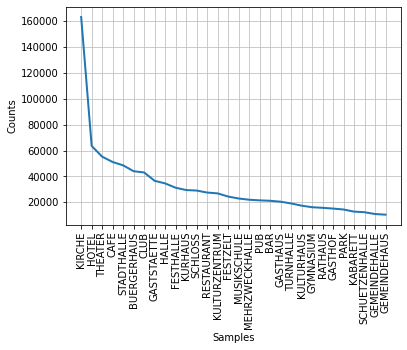

In [8]:
fdist = FreqDist(text_wo_stop_words_3)
print(fdist)
#display(fdist.most_common(60))

fdist.plot(30,cumulative=False)
plt.show()

In [9]:
most_common_terms_vg_raum = [i[0] for i in fdist.most_common(30)] 
df_featurize_vg_raum_keywords = pd.DataFrame(df_raw['VG_RAUM_clean'])

for term in most_common_terms_vg_raum :
    df_featurize_vg_raum_keywords['location_'+term]=df_featurize_vg_raum_keywords['VG_RAUM_clean'].apply(lambda x: 1 if term in x else 0)

display(df_featurize_vg_raum_keywords.head(10))

,VG_RAUM_clean,location_KIRCHE,location_HOTEL,location_THEATER,location_CAFE,location_STADTHALLE,location_BUERGERHAUS,location_CLUB,location_GASTSTAETTE,location_HALLE,location_FESTHALLE,location_KURHAUS,location_SCHLOSS,location_RESTAURANT,location_KULTURZENTRUM,location_FESTZELT,location_MUSIKSCHULE,location_MEHRZWECKHALLE,location_PUB,location_BAR,location_GASTHAUS,location_TURNHALLE,location_KULTURHAUS,location_GYMNASIUM,location_RATHAUS,location_GASTHOF,location_PARK,location_KABARETT,location_SCHUETZENHALLE,location_GEMEINDEHALLE,location_GEMEINDEHAUS
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9938765,TURNHALLE SV RW LISBERG,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
9938766,TURNHALLE SV RW LISBERG,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
9938851,WERNER VON SIEMENS SCHULZENTRUM,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9938852,PFARRHEIM UND KIRCHE,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9938853,KULTURHALLE GRAFENRHEINFELD,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9938854,VEREINSHEIM TSV FRIESENRIED,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9938855,PAUL BAECK HAUS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9938856,SPORTHEIM UND SPORTHALLE RSC OBERHAID,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9938857,DIE GOLDENE BAR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [10]:
df_featurize_vg_raum_keywords.to_pickle('./data/export_vg_raum_keywords_2016_2020.pkl.bz2', protocol=4)

## Kapelle Name

In [11]:
from nltk.corpus import stopwords

df_raw['KAPELLE_NAME_clean']=df_raw['KAPELLE_NAME'].fillna('').map(lambda x: re.sub(r'\W+', ' ', x))
df_raw['KAPELLE_NAME_tokenized'] = df_raw['KAPELLE_NAME_clean'].apply(word_tokenize, language='german')

flat_list_kapelle = [item for sublist in df_raw['KAPELLE_NAME_tokenized'].tolist() for item in sublist]

german_stop_words = stopwords.words('german')
english_stop_words = stopwords.words('english')

kapelle_wo_stop_words = [word for word in flat_list_kapelle if word.lower() not in german_stop_words]

kapelle_wo_stop_words_1 = [word for word in kapelle_wo_stop_words if word.lower() not in english_stop_words]

stopwords = [
    'BAD', 'E', 'DE', 'BIG', 'B', 'PETER', 'MARTIN', 'MICHAEL', 'MUSIC', 'MUSIK', 'THOMAS', 'BLUE', 'STEFAN',
    'N', 'ANDREAS', 'V', 'FRANK', 'U', 'KLAUS', 'TOM', 'G', 'PAUL', 'HANS', 'CHRISTIAN', 'WOLFGANG'
]
 
kapelle_wo_stop_words_2 = [word for word in kapelle_wo_stop_words_1 if word not in stopwords]

display(kapelle_wo_stop_words_2)

['BOEHMISCHE',
 'FEUER',
 'KYFFHAEUSER',
 'TANZ',
 'BAN',
 'BERUFSFACHSCHULE',
 'SIEBENBUERGER',
 'BLASMU',
 'SIEBENBUERGER',
 'BLASMU',
 'ZEPP',
 'OVERCROWDED',
 'ELEVATOR',
 'LMA',
 'ALPENBAZIS',
 'COSMODROM',
 'JAZZ',
 'BAND',
 'CABARET',
 'ROYAL',
 'RUPERT',
 'KITCHEN',
 'ORC',
 'LOCHER',
 'BAND',
 'BELCANTO',
 'VOCALE',
 'PFUNDSBUAM',
 'SCHMITT',
 'YEOMEN',
 'JAZZDUO',
 'HARNOSS',
 'FISC',
 'DJ',
 'MARIO',
 'MAYENCO',
 'DUO',
 'SEHNSUCHT',
 'CHERRY',
 'PINK',
 'TOP',
 'TEARS',
 'KERRY',
 'L',
 'DODREY',
 'BAND',
 'GERD',
 'EVELINE',
 'BETTELMUSIKANTEN',
 'DREAM',
 'TEAM',
 'BAVARIAN',
 'DUO',
 'BIERTISCH',
 'MUSI',
 'ALEX',
 'SOUL',
 'LITO',
 'JAY',
 'HOUSER',
 'BAND',
 'MOONBREAKER',
 'STELLE',
 'ZACK',
 'BERTL',
 'SEI',
 'SOUNDM',
 'SUNSPIRATION',
 'CLARN',
 'LAZIA',
 'HEINZ',
 'HELMUT',
 'DIXIE',
 'STOMPERS',
 'KARL',
 'POESL',
 'PINK',
 'VOICE',
 'CORNELIUS',
 'CLAUDIO',
 'KR',
 'GERHARD',
 'POLACEK',
 'SUNSHINE',
 'DUO',
 'KARIN',
 'GRABEIN',
 'QUARTE',
 'ALBGAU',
 'MUSIKZUG'

<FreqDist with 173976 samples and 3501595 outcomes>


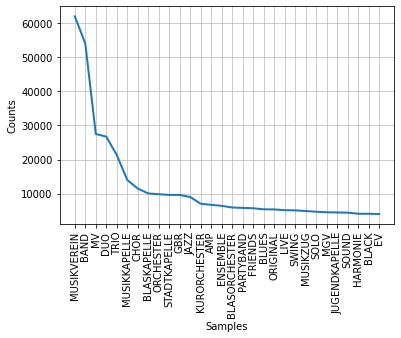

In [12]:
fdist_kapelle = FreqDist(kapelle_wo_stop_words_2)
print(fdist_kapelle)
#display(fdist_kapelle.most_common(60))

fdist_kapelle.plot(30,cumulative=False)
plt.show()

In [13]:
most_common_terms_kapelle = [i[0] for i in fdist_kapelle.most_common(30)] 
df_featurize_kapelle_keywords = pd.DataFrame(df_raw['KAPELLE_NAME_clean'])

for term in most_common_terms_kapelle :
    df_featurize_kapelle_keywords['band_'+term]=df_featurize_kapelle_keywords['KAPELLE_NAME_clean'].apply(lambda x: 1 if term in x else 0)

display(df_featurize_kapelle_keywords.head(20))

,KAPELLE_NAME_clean,band_MUSIKVEREIN,band_BAND,band_MV,band_DUO,band_TRIO,band_MUSIKKAPELLE,band_CHOR,band_BLASKAPELLE,band_ORCHESTER,band_STADTKAPELLE,band_GBR,band_JAZZ,band_KURORCHESTER,band_AMP,band_ENSEMBLE,band_BLASORCHESTER,band_PARTYBAND,band_FRIENDS,band_BLUES,band_ORIGINAL,band_LIVE,band_SWING,band_MUSIKZUG,band_SOLO,band_MGV,band_JUGENDKAPELLE,band_SOUND,band_HARMONIE,band_BLACK,band_EV
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9938765,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9938766,DAS BOEHMISCHE FEUER,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9938851,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9938852,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9938853,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9938854,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9938855,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9938856,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9938857,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
df_featurize_kapelle_keywords.to_pickle('./data/export_kapelle_keywords_2016_2020.pkl.bz2', protocol=4)

In [15]:
display(df_featurize_kapelle_keywords.info())
display(df_featurize.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3151842 entries, 9938765 to 13791338
Data columns (total 31 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   KAPELLE_NAME_clean  object
 1   band_MUSIKVEREIN    int64 
 2   band_BAND           int64 
 3   band_MV             int64 
 4   band_DUO            int64 
 5   band_TRIO           int64 
 6   band_MUSIKKAPELLE   int64 
 7   band_CHOR           int64 
 8   band_BLASKAPELLE    int64 
 9   band_ORCHESTER      int64 
 10  band_STADTKAPELLE   int64 
 11  band_GBR            int64 
 12  band_JAZZ           int64 
 13  band_KURORCHESTER   int64 
 14  band_AMP            int64 
 15  band_ENSEMBLE       int64 
 16  band_BLASORCHESTER  int64 
 17  band_PARTYBAND      int64 
 18  band_FRIENDS        int64 
 19  band_BLUES          int64 
 20  band_ORIGINAL       int64 
 21  band_LIVE           int64 
 22  band_SWING          int64 
 23  band_MUSIKZUG       int64 
 24  band_SOLO           int64 
 25  band_MGV   

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3151842 entries, 9938765 to 13791338
Data columns (total 12 columns):
 #   Column           Dtype         
---  ------           -----         
 0   VG_INKASSO       float64       
 1   VERANST_SEGMENT  float64       
 2   VG_ORT           category      
 3   VG_RAUM          category      
 4   VG_DATUM_VON     datetime64[ns]
 5   KAPELLE_NAME     object        
 6   VERANST_NAME     object        
 7   VERANST_PLZ      object        
 8   TARIF_NR         int64         
 9   LOCATION         object        
 10  BAND             object        
 11  PROMOTER         object        
dtypes: category(2), datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 287.9+ MB


None

# Time

In [16]:
df_featurize['VG_DATUM_YEAR'] = df_featurize['VG_DATUM_VON'].dt.year
df_featurize['VG_DATUM_MONTH'] = df_featurize['VG_DATUM_VON'].dt.month
df_featurize['VG_DATUM_DAY_OF_WEEK']=df_featurize['VG_DATUM_VON'].dt.dayofweek

display(df_featurize.head(5))

,VG_INKASSO,VERANST_SEGMENT,VG_ORT,VG_RAUM,VG_DATUM_VON,KAPELLE_NAME,VERANST_NAME,VERANST_PLZ,TARIF_NR,LOCATION,BAND,PROMOTER,VG_DATUM_YEAR,VG_DATUM_MONTH,VG_DATUM_DAY_OF_WEEK
ID,,,,,,,,,,,,,,,
9938765,140.0,4.0,LISBERG,TURNHALLE SV RW LISBERG,2014-02-09,NaN,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V,96194,892,LISBERG TURNHALLE SV RW LISBERG,NaN,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V 96194,2014,2,6
9938766,210.0,6.0,LISBERG,TURNHALLE SV RW LISBERG,2014-02-08,DAS BOEHMISCHE FEUER,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V,96194,892,LISBERG TURNHALLE SV RW LISBERG,DAS BOEHMISCHE FEUER,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V 96194,2014,2,5
9938851,72.5,3.0,MUENCHEN,WERNER-VON-SIEMENS-SCHULZENTRUM,2014-03-15,NaN,BLASORCHESTER ST. MICHAEL MUENCHEN-PERLACH E.V,81737,974,MUENCHEN WERNER-VON-SIEMENS-SCHULZENTRUM,NaN,BLASORCHESTER ST. MICHAEL MUENCHEN-PERLACH E.V...,2014,3,5
9938852,34.8,2.0,MUENCHEN,PFARRHEIM UND KIRCHE,2014-03-14,NaN,BLASORCHESTER ST. MICHAEL MUENCHEN-PERLACH E.V,81737,974,MUENCHEN PFARRHEIM UND KIRCHE,NaN,BLASORCHESTER ST. MICHAEL MUENCHEN-PERLACH E.V...,2014,3,4
9938853,34.8,2.0,GRAFENRHEINFELD,KULTURHALLE GRAFENRHEINFELD,2014-02-09,NaN,MUSIKVEREIN WERNECK E.V,97440,892,GRAFENRHEINFELD KULTURHALLE GRAFENRHEINFELD,NaN,MUSIKVEREIN WERNECK E.V 97440,2014,2,6


# Merge all Features

In [17]:
#df_featurize_vg_raum_keywords=pd.read_pickle('./data/export_vg_raum_keywords_2016_2020.pkl.bz2')
#df_featurize_kapelle_keywords=pd.read_pickle('./data/export_kapelle_keywords_2016_2020.pkl.bz2')

In [18]:
df_featurized_merged = df_featurize.merge(df_featurize_descr_stat, how='left', on='ID') 
df_featurized_merged = df_featurized_merged.merge(df_featurize_vg_raum_keywords, how='left', on='ID')
df_featurized_merged = df_featurized_merged.merge(df_featurize_kapelle_keywords, how='left', on='ID')

In [19]:
df_featurized_merged=df_featurized_merged.rename(str.lower, axis='columns')
df_featurized_merged=df_featurized_merged.rename(columns={"vg_inkasso": "amount", "veranst_segment": "amount_segment", "tarif_nr": "tariff_id"})
df_featurized_merged=df_featurized_merged.drop(columns=['vg_raum_clean', 'kapelle_name_clean'])

In [20]:
df_featurized_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3151842 entries, 9938765 to 13791338
Columns: 147 entries, amount to band_ev
dtypes: category(2), datetime64[ns](1), float64(74), int64(64), object(6)
memory usage: 3.5+ GB


In [21]:
df_featurized_merged.to_pickle('./data/export_features_2016_2020.pkl.bz2', protocol=4)